Data Source: https://designcensus.org/

### Import data

In [1]:
import numpy as np
import pandas as pd
import math
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import locale
locale.setlocale(locale.LC_ALL, '')
%matplotlib inline


In [2]:
df = pd.read_csv('DesignCensus2017_Data.csv', encoding = 'utf8')

In [3]:
print('There a a total of ' + str(len(df.columns)) + ' columns.')

There a a total of 43 columns.


# Part I, Pre-processing

### Column name dictionary

In [4]:
col_dict = {}
for col in df.columns:
    index, desc = col.split(' --')
    col_dict['V_' + str(index)] = desc

In [5]:
def df_with_column_names(df, col_dict):
    df_v2 = df
    df_v2.columns = [col_dict[col] for col in df_v2.columns]
    return df_v2

In [6]:
col_dict

{'V_1': " I've worked in design for:",
 'V_10': 'My immediate team is:',
 'V_11': 'My work touches these industries or sectors:',
 'V_12': 'I’ve been at my current place of work for:',
 'V_13': 'My role is:',
 'V_14': 'My role is:',
 'V_15': 'My role is:',
 'V_16': "I've been in my current role for:",
 'V_17': 'I typically work:',
 'V_18': 'My annual salary is:',
 'V_19': 'My job provides:',
 'V_2': 'I primarily work in:',
 'V_20': 'In my current role, there is:',
 'V_21': 'In my current role, I am:',
 'V_22': 'My job is:',
 'V_23': 'My job stability is:',
 'V_24': 'In addition to my job, I also:',
 'V_25': 'I fuel my daily creativity with coffee:',
 'V_26': "Highest level of education I've completed:",
 'V_27': 'I learned design:',
 'V_28': 'My major focus of study was:',
 'V_29': "Over my career, I've had:",
 'V_3': "I'm also good at:",
 'V_30': "I've shifted my specialty or focus area:",
 'V_31': 'I stay current with design by:',
 'V_32': "I'm a member of:",
 'V_33': "I'd like to ge

### Classify columns (continuous, categorical, multiple pipe)

In [7]:
df.columns = map(lambda x : 'V_' + str(x+1), list(range(len(df.columns)))) 

In [8]:
continous_cols = ['V_18', 'V_37']

In [9]:
pipe_col = ['V_2', 'V_3','V_5','V_7','V_11','V_19',\
            'V_24', 'V_27', 'V_28', 'V_31', 'V_32',\
            'V_33', 'V_40', 'V_41', 'V_42', 'V_43']

In [10]:
cate_cols = list(set(df.columns) - set(continous_cols))
cate_cols.sort(key = lambda x : int(x.split('_')[1]))

### Summary of null value for each column

In [11]:
dff = pd.DataFrame(columns=['Column','Desc', 'Null'])
for col in df.columns:
    num_null = df[col].isnull().sum()
    dff = dff.append({'Column': col, 'Desc' : col_dict[col], 'Null' : num_null }, ignore_index=True)
dff

,Column,Desc,Null
0,V_1,I've worked in design for:,0
1,V_2,I primarily work in:,0
2,V_3,I'm also good at:,0
3,V_4,I am currently:,0
4,V_5,My company specializes in:,7198
5,V_6,My company is:,7317
6,V_7,I teach:,12800
7,V_8,I'm not working because:,12831
8,V_9,My organization has:,409
9,V_10,My immediate team is:,402


### Take a look at Salary Outliers

In [12]:
print('The 99% percentile of salary is: ' + \
      str(int(np.percentile(df.V_18.dropna(), 99))))

print('The 90% percentile of salary is: ' + \
      str(int(np.percentile(df.V_18.dropna(), 90))))

print('The 85% percentile of salary is: ' + \
      str(int(np.percentile(df.V_18.dropna(), 85))))

The 99% percentile of salary is: 210799
The 90% percentile of salary is: 120000
The 85% percentile of salary is: 103000


Text(50.5228,0.5,'Age')

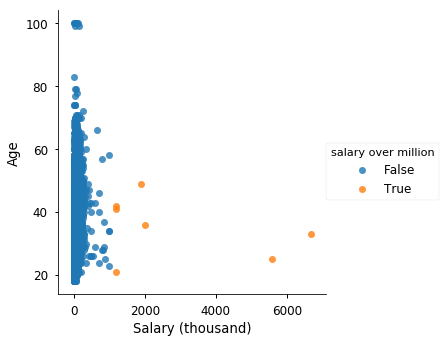

In [13]:
# take a look at salary vs. age
dff = pd.DataFrame()
dff['salary'] = df['V_18'] / 1000
dff['age'] = df['V_37']
dff['salary over million'] = dff['salary'] > 1000
sns.lmplot(data = dff, x = 'salary', y = 'age', fit_reg = False, hue = 'salary over million')
plt.xlabel('Salary (thousand)')
plt.ylabel('Age')

In [14]:
# export a separate file with salary over million record
# df_with_column_names(df[df.V_18 > 1000000], col_dict).to_csv('output_salary_over_million.csv', index = False)

### Break "Age" into groups

In [15]:
def age_break(x):
    if (x < 20): return ('Younger than 20')
    elif (x <= 25): return ('20 to 25')
    elif (x <= 30): return ('25 to 30')
    elif (x <= 35): return ('30 to 35')
    elif (x <= 40): return ('35 to 40')
    elif (x <= 45): return ('40 to 45')
    elif (x <= 50): return ('45 to 50')
    else: return ('Older than 50')

df['V_37'] = df['V_37'].apply(lambda x : age_break(x))
cate_cols.append('V_37')
continous_cols.remove('V_37')

### Exclude outliers for salary

In [16]:
## Remove outliers for salary
# 1. Null values 
# 2. zero salary
# 3. Top 1% salary

df = df[~((df.V_18.isnull()) | 
          (df.V_18 == 0) | 
          (df.V_18 > 210000))]

df = df.reset_index()
df = df.drop('index', axis = 1)

### **Done for Jon to export raw data with and without salary outliers

In [ ]:
raw_df = pd.read_csv('DesignCensus2017_Data.csv')
salary = raw_df['18 --My annual salary is:']
raw_df_salary_outliers  = raw_df [((salary.isnull()) | (salary == 0) | (salary > 210000))]
raw_df_excluding_outliers  = raw_df [~((salary.isnull()) | (salary == 0) | (salary > 210000))]
raw_df_salary_outliers.to_csv('./export_csv/raw_data_salary_outliers.csv', index = False, encoding = 'utf8')
raw_df_excluding_outliers.to_csv('./export_csv/raw_data_excluding_salary_outliers.csv', index = False, encoding = 'utf8')
del raw_df, raw_df_salary_outliers, raw_df_excluding_outliers

### Script to deal with columns with pipe

In [17]:
df['V_36'] = df['V_36'].astype(np.object)
df = df.replace(np.nan,'', regex=True)
pipe_col_dict = {}

for col in pipe_col:
    options = set()
    for row in df[col]:
        arrs = row.split('|') 
        for arr in arrs:
            if arr != '':
                options.add(arr)
    
    pipe_col_dict[col] = {}
    
    index = 1
    for option in options:
        sub_col = col + '_' + str(index)
        df.loc[:,sub_col] = 0
        pipe_col_dict[col][option] = sub_col
        col_dict[sub_col] = col_dict[col] + '-' + option
        index += 1

In [ ]:
# this part takes a few minutes to run
for col in pipe_col:
    row_num = 0;
    for row in df[col]:
        arrs = row.split('|') 
        for arr in arrs:
            if arr != '':
                sub_col = pipe_col_dict[col][arr]
                df.loc[row_num, sub_col] += 1
        row_num += 1

### Output csv w/ and w/o column names

In [ ]:
df.to_csv('./export_csv/processed_output_without_column_names.csv', index = False, encoding = 'utf8')

In [ ]:
df_with_column_names(df, col_dict).to_csv(\
    './export_csv/processed_output_with_column_names.csv', index = False, encoding = 'utf8')    

# Part II, Analysis

### Read in processed data

In [18]:
df = pd.read_csv('./export_csv/processed_output_without_column_names.csv', encoding = 'utf8')
num_records = len(df)

### Basic Summary of each column (only show `top k`)

In [19]:
def summary_cate_col(col, top_k):
    if col in continous_cols:
        return
    
    elif col in pipe_col:
        dff = pd.DataFrame(columns=['Options','Count','Percent'])
        for key, value in pipe_col_dict[col].items():
            count = df[value].sum()
            dff = dff.append({'Options': key, 'Count' : count}, ignore_index=True)
    
    else:
        dff = pd.DataFrame(df[col].value_counts())
        dff.reset_index(inplace=True)
        dff.columns = ['Options','Count']
    
    dff['Percent'] = dff.Count / num_records
    dff = dff.sort_values(by = 'Percent', ascending = False).head(top_k)
    dff = dff.style.format({'Percent': '{:,.2%}'.format})
    return dff

### Distribution (%) for each column

In [20]:
for col in cate_cols:
    if 'V_8' in col:
        continue
    if 'V_35' in col:
        continue
    if 'V_36' in col:
        continue
    display(str(col) + ' : ' + col_dict[col])
    display(summary_cate_col(col, 1000))

"V_1 :  I've worked in design for:"

,Options,Count,Percent
0,1-4 years,3954,31.69%
1,5-9 years,3597,28.83%
2,10-14 years,1986,15.92%
3,15-20 years,1234,9.89%
4,20+ years,1148,9.20%
5,Less than 1 year,558,4.47%


'V_2 : I primarily work in:'

,Options,Count,Percent
11,Production,8537,68.42%
23,Instructional Design,4709,37.74%
28,Industrial Design,4097,32.84%
1,Experience Design,3801,30.46%
0,Packaging Design,3793,30.40%
30,Web Design,3425,27.45%
31,Education,2476,19.84%
9,Research,2356,18.88%
17,Social Impact Design,2348,18.82%
29,Interaction Design,2103,16.86%


"V_3 : I'm also good at:"

,Options,Count,Percent
14,Project Management,9710,77.82%
13,Coding,5441,43.61%
4,Diversity and Inclusion,4969,39.83%
5,Public Speaking,4960,39.75%
16,Facilitation,4570,36.63%
7,Engineering,4395,35.22%
10,Business,3963,31.76%
15,Data Analysis,2995,24.00%
9,None of these,2690,21.56%
8,SEO/SEM,2466,19.76%


'V_4 : I am currently:'

,Options,Count,Percent
0,A full-time employee in-house,5453,43.70%
1,A full-time employee at an agency or consultancy,3690,29.57%
2,Self-employed or freelancing,1932,15.48%
3,A contract employee in-house,395,3.17%
4,An educator,382,3.06%
5,Other,324,2.60%
6,A contract employee at an agency or consultancy,301,2.41%


'V_5 : My company specializes in:'

,Options,Count,Percent
0,Service Design,3337,26.75%
5,Print,2928,23.47%
1,Product Design,2330,18.67%
6,Social Impact,2046,16.40%
4,Strategy,2039,16.34%
2,Digital,1315,10.54%
10,Advertising,1067,8.55%
3,Innovation,860,6.89%
7,None of these,718,5.75%
9,Branding,413,3.31%


'V_6 : My company is:'

,Options,Count,Percent
0,For-Profit/Corporate,3662,29.35%
1,Startup,676,5.42%
2,Non-Profit,600,4.81%
3,Education,447,3.58%
4,Other,214,1.72%
5,Government,151,1.21%


'V_7 : I teach:'

,Options,Count,Percent
3,Technical or Trade school,261,2.09%
2,Undergraduate school,116,0.93%
5,Programs or workshops,82,0.66%
6,Junior High or High school,65,0.52%
0,Art school,34,0.27%
4,Elementary school,28,0.22%
1,Graduate school,5,0.04%


'V_9 : My organization has:'

,Options,Count,Percent
0,1-10 employees,3144,25.20%
1,1000+ employees,2832,22.70%
2,11-50 employees,2387,19.13%
3,101-250 employees,1136,9.10%
4,51-100 employees,1125,9.02%
5,251-500 employees,862,6.91%
6,501-1000 employees,719,5.76%
7,Not sure,263,2.11%


'V_10 : My immediate team is:'

,Options,Count,Percent
0,2-4 people,4842,38.81%
1,5-10 people,3747,30.03%
2,Just me,2229,17.86%
3,11-20 people,1160,9.30%
4,20+ people,494,3.96%


'V_11 : My work touches these industries or sectors:'

,Options,Count,Percent
45,Accounting,5301,42.49%
9,Gaming,5129,41.11%
5,Shipping,4100,32.86%
41,Government,4025,32.26%
40,Real Estate,3527,28.27%
14,Legal,3409,27.32%
18,Marketing and Communications,3380,27.09%
20,Travel and Tourism,3348,26.83%
48,Construction,2955,23.68%
3,Mining,2719,21.79%


'V_12 : I’ve been at my current place of work for:'

,Options,Count,Percent
0,1-2 years,3730,29.90%
1,Less than 1 year,3534,28.32%
2,3-4 years,2467,19.77%
3,5-7 years,1196,9.59%
4,10+ years,1066,8.54%
5,8-10 years,479,3.84%


'V_13 : My role is:'

,Options,Count,Percent
0,Mid-level specialist,1416,11.35%
1,Owner/Partner,1393,11.16%
2,Art Director,751,6.02%
3,Junior contributor,618,4.95%
4,Creative Director,557,4.46%
5,Other,522,4.18%
6,Senior manager,322,2.58%
7,Director,149,1.19%
8,Intern,98,0.79%
9,Executive,88,0.71%


'V_14 : My role is:'

,Options,Count,Percent
0,Mid-level specialist,2758,22.10%
1,Junior contributor,711,5.70%
2,Director,561,4.50%
3,Senior manager,559,4.48%
4,Team Leader,520,4.17%
5,Other,427,3.42%
6,Group Leader,128,1.03%
7,Executive,73,0.59%
8,Senior Executive,60,0.48%
9,Intern,45,0.36%


'V_15 : My role is:'

,Options,Count,Percent
0,Associate Professor,121,0.97%
1,Professor,59,0.47%
2,Instructor,56,0.45%
3,Program Chair,48,0.38%
4,Other,39,0.31%
5,Lecturer,29,0.23%
6,Adjunct Professor,24,0.19%
7,Associate Dean,3,0.02%
8,Dean,3,0.02%


"V_16 : I've been in my current role for:"

,Options,Count,Percent
0,1-2 years,4352,34.88%
1,Less than 1 year,3865,30.98%
2,3-4 years,2192,17.57%
3,5-7 years,928,7.44%
4,10+ years,769,6.16%
5,8-10 years,366,2.93%


'V_17 : I typically work:'

,Options,Count,Percent
0,40 hours per week,5553,44.51%
1,41-50 hours per week,4070,32.62%
2,Less than 40 hours per week,1913,15.33%
3,51-60 hours per week,695,5.57%
4,60+ hours per week,241,1.93%


'V_19 : My job provides:'

,Options,Count,Percent
7,None of these,8731,69.98%
12,Profit Sharing or Stock Options,8609,69.00%
8,Professional Memberships,7414,59.42%
14,Disability Insurance,5759,46.16%
3,Medical Insurance,5733,45.95%
2,Education Funding,5583,44.75%
11,Paid Time Off,4781,38.32%
10,Employer-matched Retirement,4471,35.83%
6,Child Care,3574,28.64%
9,Dental Insurance,3499,28.04%


'V_20 : In my current role, there is:'

,Options,Count,Percent
0,Some opportunity for advancement,3880,31.10%
1,Promising opportunity for advancement,3256,26.10%
2,Limited opportunity for advancement,3093,24.79%
3,No opportunity for advancement,1478,11.85%
4,Not sure,767,6.15%


'V_21 : In my current role, I am:'

,Options,Count,Percent
0,Learning some new skills,5439,43.59%
1,Learning and increasing my skill set every day,5018,40.22%
2,Learning very little,1699,13.62%
3,Learning nothing,249,2.00%
4,Not sure,69,0.55%


'V_22 : My job is:'

,Options,Count,Percent
0,Pretty good,8014,64.23%
1,The best,2161,17.32%
2,Not great,1942,15.56%
3,Not sure,194,1.55%
4,The worst,163,1.31%


'V_23 : My job stability is:'

,Options,Count,Percent
0,Fairly stable,7152,57.32%
1,Rock solid,3154,25.28%
2,Somewhat shaky,1580,12.66%
3,Non-existent,408,3.27%
4,Not sure,180,1.44%


'V_24 : In addition to my job, I also:'

,Options,Count,Percent
7,Volunteer,6966,55.83%
2,Maintain personal projects,6814,54.61%
5,None of these,6177,49.51%
0,Own my own business,3986,31.95%
1,Design for friends and family,2154,17.26%
4,Take occasional freelance projects,2011,16.12%
3,Teach,1361,10.91%
8,Have a part-time job,965,7.73%
6,Have regular freelance clients,690,5.53%


'V_25 : I fuel my daily creativity with coffee:'

,Options,Count,Percent
0,1-2 cups,5982,47.94%
1,3-4 cups,2349,18.83%
2,"No way, tea",2102,16.85%
3,Other,1439,11.53%
4,5-6 cups,459,3.68%
5,7-8 cups,99,0.79%
6,10+ cups,29,0.23%
7,9-10 cups,18,0.14%


"V_26 : Highest level of education I've completed:"

,Options,Count,Percent
0,Bachelor's degree,8613,69.03%
1,Master's degree,2117,16.97%
2,Some college,628,5.03%
3,Associate's degree,545,4.37%
4,Technical degree or certificate,284,2.28%
5,High School or less,199,1.59%
6,Doctorate,91,0.73%


'V_27 : I learned design:'

,Options,Count,Percent
2,In school,10055,80.59%
4,On my own,8861,71.02%
5,From a mentor or apprenticeship,8014,64.23%
1,On the job,4554,36.50%
3,From programs or workshops,3970,31.82%
0,Through online training,3810,30.54%


'V_28 : My major focus of study was:'

,Options,Count,Percent
13,Animation,8470,67.88%
24,Multimedia,2821,22.61%
29,Fashion Design,2424,19.43%
12,Package Design,2080,16.67%
1,Graphic Design,2050,16.43%
30,Interior Architecture,1938,15.53%
32,Motion Graphics,1937,15.52%
19,Journalism,1697,13.60%
11,Visual Design,1645,13.18%
6,Illustration,1580,12.66%


"V_29 : Over my career, I've had:"

,Options,Count,Percent
0,2-3 design jobs,5729,45.92%
1,4-5 design jobs,3052,24.46%
2,1 design job,1736,13.91%
3,6-7 design jobs,1029,8.25%
4,10+ design jobs,545,4.37%
5,8-10 design jobs,386,3.09%


"V_30 : I've shifted my specialty or focus area:"

,Options,Count,Percent
0,1-2 times,6228,49.92%
1,0 times,2967,23.78%
2,3-4 times,1172,9.39%
3,Slowly over time,1095,8.78%
4,Always ready for what's next,1015,8.13%


'V_31 : I stay current with design by:'

,Options,Count,Percent
7,Attending conferences,10127,81.17%
5,Discussing with peers,9563,76.65%
3,Reading books/magazines,9151,73.34%
2,Reading online publications,8760,70.21%
4,Having a mentor,7084,56.78%
1,Following design feeds,5932,47.54%
0,Seeking online training,5713,45.79%
6,None of these,1910,15.31%
8,Following social media,153,1.23%


"V_32 : I'm a member of:"

,Options,Count,Percent
20,UCDA,6371,51.06%
5,SPD,4638,37.17%
9,D&AD,1726,13.83%
24,AIGA,718,5.75%
25,IXDA,395,3.17%
11,Graphic Artists Guild,320,2.56%
21,Freelancers Union,169,1.35%
27,SOD,138,1.11%
2,ADCE,131,1.05%
22,Society of Illustrators,130,1.04%


"V_33 : I'd like to get better at:"

,Options,Count,Percent
25,Relationship Management,5396,43.25%
22,Project Management,4818,38.62%
0,Mentoring,4647,37.24%
12,Photography,4488,35.97%
6,VR or AR Design,4460,35.75%
14,Social Impact Design,4375,35.06%
29,Engineering,4353,34.89%
28,Web Design,4117,33.00%
7,Research,3686,29.54%
3,Data Analysis,3661,29.34%


'V_34 : I am:'

,Options,Count,Percent
0,"Open to opportunities, but not actively looking",5662,45.38%
1,Not interested in a new job right now,2851,22.85%
2,Casually looking for the right opportunity,2591,20.77%
3,Working hard to find my next job,1254,10.05%
4,Not sure,119,0.95%


'V_38 : I am:'

,Options,Count,Percent
0,Female,6718,53.84%
1,Male,5558,44.55%
2,Prefer not to say,98,0.79%
3,Non-binary or third gender,95,0.76%
4,Other,8,0.06%


'V_39 : I consider myself:'

,Options,Count,Percent
0,Not LGBTQ,10018,80.29%
1,LGBTQ,1418,11.36%
2,Prefer not to say,1041,8.34%


'V_40 : My ethnicity is:'

,Options,Count,Percent
5,Native Hawaiian or Pacific Islander,9215,73.86%
7,Asian,1517,12.16%
3,"Latina, Latino, Latinx, or Hispanic",1222,9.79%
0,Prefer not to say,500,4.01%
6,Other,362,2.90%
2,Black or African American,317,2.54%
1,White or Caucasian,147,1.18%
4,"Native American, First Nations, or First People",123,0.99%


'V_41 : The most critical issues and challenges currently facing design are (answer optional):'

,Options,Count,Percent
2,Environmental impacts of design,5803,46.51%
6,Consumer vs. social impact focus,5301,42.49%
1,Generational differences in the workforce,4847,38.85%
5,Education cost and equity of access,4317,34.60%
9,Software complexity,3727,29.87%
7,Diversity in design and tech,3589,28.76%
10,None of these,3358,26.91%
0,Human-machine interface limitations,1961,15.72%
12,Advertising supported content model,1826,14.63%
11,Trademark and patent issues,1725,13.83%


'V_42 : The emerging trends and technologies that will have the biggest impact on design are (answer optional):'

,Options,Count,Percent
10,Human augmentation,6660,53.38%
17,Conversational interfaces,5076,40.68%
2,Augmented Reality,4815,38.59%
8,Biological or genetic design,4334,34.74%
15,Networked device ubiquity,3629,29.09%
7,Crowdsourcing and open source,3373,27.03%
11,Miniaturization and nanotechnology,3313,26.55%
19,Battery and energy technology,3275,26.25%
13,None of these,3100,24.85%
16,Facial and voice recognition,2818,22.59%


'V_43 : The most valuable design skills for the future will be (answer optional):'

,Options,Count,Percent
11,Algorithm and data model design,8726,69.94%
6,Asking good questions,7286,58.40%
15,Scientific methods,5927,47.50%
22,Psychology and human behavior,5440,43.60%
19,Play,5239,41.99%
12,Facilitation,5189,41.59%
8,Improvisation,4926,39.48%
5,Data analysis,4829,38.70%
7,Interpersonal skills,4682,37.53%
13,Voice interface design,4662,37.36%


'V_37 : My age is:'

,Options,Count,Percent
0,25 to 30,3809,30.53%
1,20 to 25,2625,21.04%
2,30 to 35,2541,20.37%
3,35 to 40,1363,10.92%
4,40 to 45,845,6.77%
5,Older than 50,686,5.50%
6,45 to 50,563,4.51%
7,Younger than 20,45,0.36%


### Plot `salary` vs. all columns (barplots)

In [21]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [22]:
# 1. For columns without pipes
cate_cols_v2 = list(set(cate_cols) - set(pipe_col))
cate_cols_v2.remove('V_35') # "Right now, I can't stop listening to:" - No fixed options
cate_cols_v2.remove('V_36') # "I live in:" - Zipcode
cate_cols_v2.remove('V_8') # "I'm not working because:" - null
cate_cols_v2.sort(key = lambda x : int(x.split('_')[1]))

In [29]:
# All figs are saved under 'fig' folder
sns.set_context("notebook", font_scale=2)
for col in cate_cols_v2:
    groupedvalues = df.groupby(col, as_index = False).agg({'V_18': [np.mean, percentile(95), percentile(5)]})
    groupedvalues.columns = [col, 'V_18_avg', 'V_18_max', 'V_18_min']
    groupedvalues.sort_values(by = 'V_18_avg', inplace=True)
    order = list(groupedvalues[col])
    
    plt.figure(figsize=(15,10))
    g=sns.barplot(x='V_18', y=col, data=df, estimator= np.mean, \
                order = order,  palette="Blues_d", ci = None)
    plt.xlim(0,150000)#max(groupedvalues['V_18_avg']) + 40000)  
    
    # add data labels
    ax = plt.gca()
    for p,vmin,vavg,vmax in zip(ax.patches,groupedvalues['V_18_min'],groupedvalues['V_18_avg'],groupedvalues['V_18_max']):
        ax.annotate('5%: ' + "{0:n}".format(int(vmin)) +  # value
                    '\nAvg: ' + "{0:n}".format(int(vavg)) +
                    '\n95%: ' + "{0:n}".format(int(vmax)),
                    (p.get_x() + p.get_width(),p.get_y()+0.5*p.get_height()),# location
                    xytext=(5, 0), textcoords='offset points',# offset
                    va="center", size = 16) #text align and font size
        
    #plot axes and export
    plt.xlabel('Salary')
    plt.ylabel(col_dict[col])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('./fig/'+ 'Salary vs. ' + col_dict[col] + '_Plot.png',dpi=100)
    plt.gcf().clear()

/Users/shiwang/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [30]:
# 2. For columns with pipes
dff = pd.DataFrame(columns = ['Col', 'Option', 'Salary'])
for col in pipe_col:
    for option, sub_col in pipe_col_dict[col].items():
        salary_avg = df.loc[df[sub_col] == 1, 'V_18'].mean()
        salary_min = np.percentile(df.loc[df[sub_col] == 1, 'V_18'],5)
        salary_max = np.percentile(df.loc[df[sub_col] == 1, 'V_18'],95)
        dff = dff.append({'Col': col, 'Option' : option, 'Salary_min' : salary_min,
                          'Salary_avg' : salary_avg, 'Salary_max' : salary_max}, \
                         ignore_index=True)

In [31]:
# All figs are saved under 'fig' folder
sns.set_context("notebook", font_scale=1.5)
for col in pipe_col:
    dfff = dff[dff.Col == col].sort_values(by = 'Salary_avg')
    order = list(dfff['Option'])
    plt.figure(figsize=(15,10))
    sns.barplot(x = 'Salary_avg', y = 'Option', data = dfff, estimator= np.mean, \
                order = order, palette="Blues_d")
    plt.xlim(0, max(150000, max(dfff['Salary_avg']) + 100000)) 
    
    # add data labels
    ax = plt.gca()
    for p,vmin,vavg,vmax in zip(ax.patches,dfff['Salary_min'], dfff['Salary_avg'],dfff['Salary_max']):
        ax.annotate('5%: ' + "{0:n}".format(int(vmin)) +  # value
                    '; Avg: ' + "{0:n}".format(int(vavg)) +
                    '; 95%: ' + "{0:n}".format(int(vmax)),
                    (p.get_x() + p.get_width(),p.get_y()+0.5*p.get_height()),# location
                    xytext=(5, 0), textcoords='offset points',# offset
                    va="center", size = 12) #text align and font size 
    #plot axes and export    
    plt.xlabel('Salary')
    plt.ylabel(col_dict[col])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('./fig/'+ 'Salary vs. ' + col_dict[col] + '_Plot.png',dpi=100)
    plt.gcf().clear()

# Part III, Heatmaps

In [32]:
df = pd.read_csv('./export_csv/processed_output_without_column_names.csv', encoding = 'utf8')

### **Heatmap Analysis

In [33]:
def plot_heatmap(raw_df, col_1, col_1_desc, col_2, col_2_desc, col_salary):
    df = raw_df.copy()
    sns.set(font_scale = 1.4)
    df[col_salary] = df[col_salary].apply(lambda x : np.round_(x/1000))
    pivot_table=pd.pivot_table(df, index=col_1, columns=col_2, 
                               values = col_salary, aggfunc=np.mean)
    sns.heatmap(pivot_table, annot=True)
    plt.xlabel(col_2_desc)
    plt.ylabel(col_1_desc)
    plt.title('Average Salary Comparison (K)')

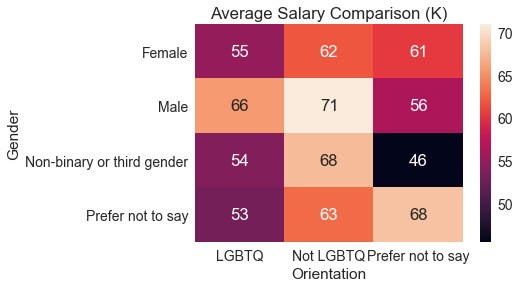

In [ ]:
# 1. Gender and Orientation Combo
plot_heatmap(df[df['V_38'] != 'Other'], # exclude GENDER == 'Other'
             'V_38', 'Gender', 
             'V_39', 'Orientation',
             'V_18') #salary

In [38]:
# 2. Process RACE and combine with GENDER, ORIENTATION (duplicate rows)
hm_heat = pd.DataFrame(columns=['index','Gender', 'Orientation','Race', 'Salary'])# v38, v39, v40, v18
for index, row in df.iterrows():
    for option, subcol in pipe_col_dict['V_40'].items(): #race
        if row[subcol] == 1:
            hm_heat = hm_heat.append({'index': index,
                                      'Gender': row['V_38'],  #gender
                                      'Orientation': row['V_39'], #orientation
                                      'Race': option, 
                                      'Salary': row['V_18']}, ignore_index=True)

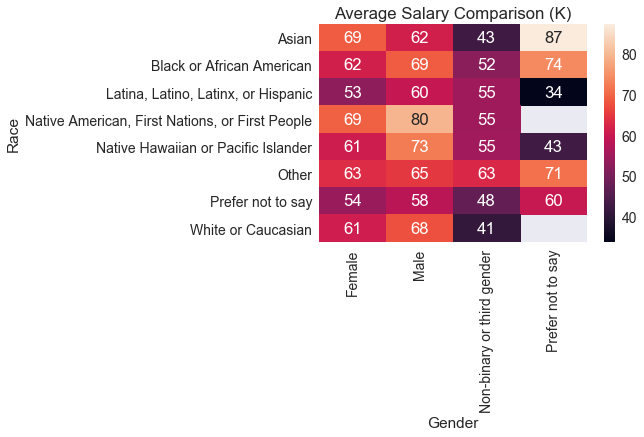

In [39]:
# 2. Race and Gender Combo
plot_heatmap(hm_heat[hm_heat['Gender'] != 'Other'], # exclude GENDER == 'Other'
             'Race', 'Race',
             'Gender', 'Gender', 
             'Salary') #salary

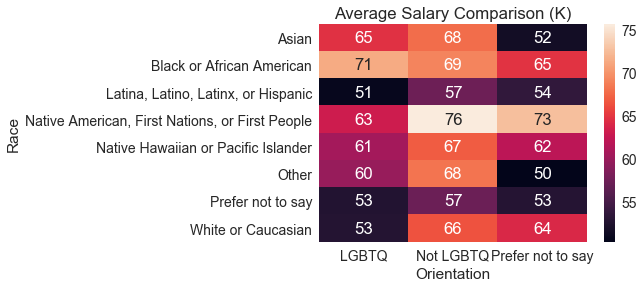

In [40]:
# 3. Race and Orientation Combo
plot_heatmap(hm_heat[hm_heat['Gender'] != 'Other'], # exclude GENDER == 'Other'
             'Race', 'Race',
             'Orientation', 'Orientation', 
             'Salary') #salary

### (Not used now) Generate one-hot coded columns for categorical variables

In [ ]:
for col in cate_cols_v2:
    df.replace(np.nan,'', regex=True, inplace=True)
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(df[col])
    feature = feature.reshape(df.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    feature = onehot_encoder.fit_transform(feature)
    for i in range(feature.shape[1]):
        df[col + '-' + str(i + 1)] = np.array(np.matrix(feature).transpose())[i]
        col_dict[col + '-' + str(i + 1)] = col_dict[col] + '-' + label_encoder.classes_[i]
    df.drop(col, axis = 1, inplace = True)

for col in pipe_col:
    df.drop(col, axis = 1, inplace = True)

for col in ['V_8', 'V_35', 'V_36']:
    df.drop(col, axis = 1, inplace = True)

In [ ]:
# output a csv with all columns converted to numeric
df.to_csv('./export_csv/processed_output_all_numeric.csv', index = False)